# Spectrally Normalized Generative Adversarial Networks (SN-GAN)

In this notebook, you'll learn about and implement spectral normalization, a weight normalization technique to stabilize the training of the discriminator, as proposed in Spectral Normalization for Generative Adversarial Networks (Miyato et al. 2018).

## Background

As its name suggests, SN-GAN normalizes the weight matrices in the discriminator by their corresponding spectral norm, which helps control the Lipschitz constant of the discriminator. With WGAN, Lipschitz continuity is important in ensuring the boundedness of the optimal discriminator. In the WGAN case, this makes it so that the underlying W-loss function for the discriminator (or more precisely, the critic) is valid.

As a result, spectral normalization helps improve stability and avoid vanishing gradient problems, such as mode collapse.



## Spectral Norm
Notationally, the spectral norm of a matrix  𝑊
  is typically represented as  𝜎(𝑊)
 . For neural network purposes, this  𝑊
  matrix represents a weight matrix in one of the network's layers. The spectral norm of a matrix is the matrix's largest singular value, which can be obtained via singular value decomposition (SVD).

### A Quick Refresher on SVD

SVD is a generalization of eigendecomposition and is used to factorize a matrix as  𝑊=𝑈Σ𝑉⊤
 , where  𝑈,𝑉
  are orthogonal matrices and  Σ
  is a matrix of singular values on its diagonal. Note that  Σ
  doesn't have to be square.

Σ=𝜎1𝜎2⋱𝜎𝑛
 
where  𝜎1
  and  𝜎𝑛
  are the largest and smallest singular values, respectively. Intuitively, larger values correspond to larger amounts of stretching a matrix can apply to another vector. Following this notation,  𝜎(𝑊)=𝜎1
 .

### Applying SVD to Spectral Normalization

To spectrally normalize the weight matrix, you divide every value in the matrix by its spectral norm. As a result, a spectrally normalized matrix  𝑊⎯⎯⎯⎯⎯⎯⎯𝑆𝑁
  can be expressed as

𝑊⎯⎯⎯⎯⎯⎯⎯𝑆𝑁=𝑊𝜎(𝑊),
 
In practice, computing the SVD of  𝑊
  is expensive, so the authors of the SN-GAN paper do something very neat. They instead approximate the left and right singular vectors,  𝑢̃ 
  and  𝑣̃ 
  respectively, through power iteration such that  𝜎(𝑊)≈𝑢̃ ⊤𝑊𝑣̃ 
 .

Starting from randomly initialization,  𝑢̃ 
  and  𝑣̃ 
  are updated according to

𝑢̃  :=𝑊⊤𝑢̃ ||𝑊⊤𝑢̃ ||2
𝑣̃  :=𝑊𝑣̃ ||𝑊𝑣̃ ||2
 
In practice, one round of iteration is sufficient to "achieve satisfactory performance" as per the authors.

Don't worry if you don't completely follow this! The algorithm is conveniently implemented as torch.nn.utils.spectral_norm in PyTorch, so as long as you get the general gist of how it might be useful and when to use it, then you're all set.

In [1]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
# DCGAN Generator
# Since spectral normalization is only applied to the matrices in the discriminator, the generator implementation is the same as the original.
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)


# DCGAN Discriminator
For the discriminator, you can wrap each nn.Conv2d with nn.utils.spectral_norm. In the backend, this introduces parameters for  𝑢̃ 
  and  𝑣̃ 
  in addition to  𝑊
  so that the  𝑊𝑆𝑁
  can be computed as  𝑢̃ ⊤𝑊𝑣̃ 
  in runtime.

Pytorch also provides a nn.utils.remove_spectral_norm function, which collapses the 3 separate parameters into a single explicit  𝑊⎯⎯⎯⎯⎯⎯⎯𝑆𝑁:=𝑢̃ ⊤𝑊𝑣̃ 
 . You should only apply this to your convolutional layers during inference to improve runtime speed.

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer. You can see both in a discriminator architecture, but you can also see just one of them. Hope this is something you have fun experimenting with!

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# Training SN-DCGAN
You can now put everything together and train a spectrally normalized DCGAN! Here are all your parameters for initialization and optimization.

In [6]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5 
beta_2 = 0.999
device = 'cpu' #'cuda

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [7]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.8069743390083315, discriminator loss: 0.6110356611013408


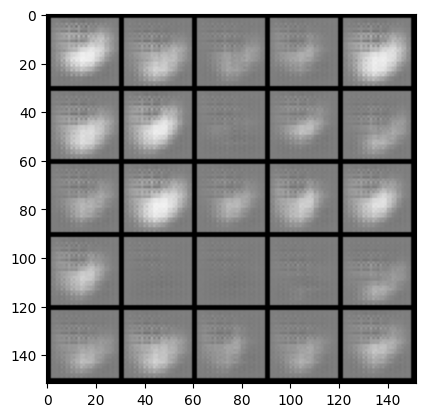

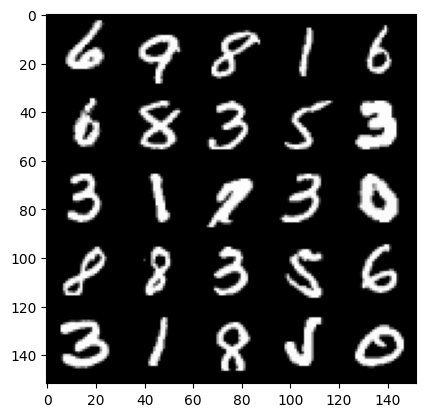

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.1835576775074004, discriminator loss: 0.4068363268971444


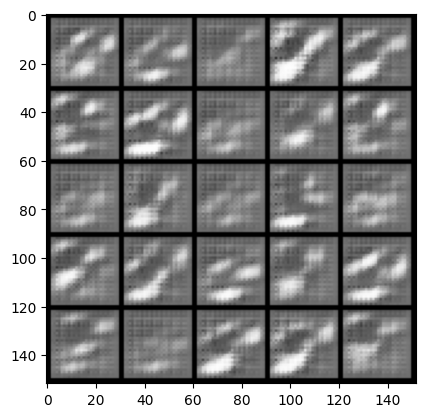

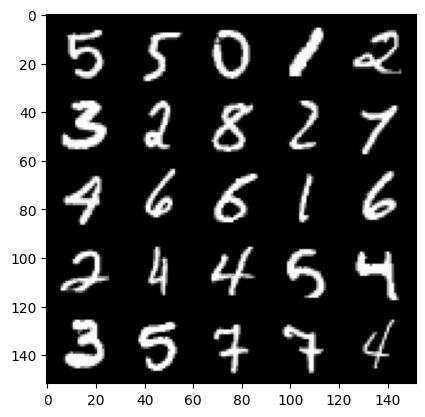

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1